In [1]:
# ==============================================================================
# 🚀 ULTIMATE CNN TEMPLATE: COLAB TURBO EDITION (EFFICIENTNET-B0)
# Optimized for: Google Colab GPU (Tesla T4)
# Features: Mixed Precision (Speedup), High Batch Size, Auto-Fix Dataset
# ==============================================================================

import tensorflow as tf
from tensorflow.keras import mixed_precision
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import json
from google.colab import drive, files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

In [2]:
# ==========================================
# 0. AKTIFKAN TURBO MODE (MIXED PRECISION) ⚡
# ==========================================
# Ini bikin GPU T4 kerja 2x lebih cepat & hemat memori
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print(f"⚡ TURBO MODE AKTIF: {policy.compute_dtype}")
except Exception as e:
    print("⚠️ Gagal aktifkan Mixed Precision (Gak masalah, lanjut standar).")

⚡ TURBO MODE AKTIF: float16


In [3]:
# ==========================================
# 1. KONFIGURASI "MAX PERFORMANCE" 🛠️
# ==========================================
# 👇 GANTI BAGIAN INI (Sesuaikan nama file zip kamu, misal: dataset.zip)
PATH_ZIP_DRIVE = '/content/drive/MyDrive/dataset-ikan/dataset.zip'

MODEL_NAME = 'model_klasifikasi_pro.h5'
JSON_NAME = 'labels.json'

# Settingan "Siksa Hardware"
IMG_SIZE = 260   # Resolusi Tinggi (Biar detail sisik ikan kelihatan)
BATCH_SIZE = 64  # Kita hajar 64 (GPU T4 Kuat kok!)
EPOCHS_1 = 15    # Pemanasan
EPOCHS_2 = 40    # Fine Tuning (Lama dikit biar loss 0.1)

In [4]:
# ==========================================
# 2. SETUP & EXTRACT (MODE ROBOFLOW) 📦
# ==========================================
print("\n🚀 MEMULAI PERSIAPAN DATASET (ROBOFLOW)...")

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Lokasi Ekstrak (Kita bikin folder baru biar bersih)
base_dir = '/content/dataset_roboflow'
if os.path.exists(base_dir): shutil.rmtree(base_dir)
os.makedirs(base_dir)

print(f"📂 Mengekstrak: {PATH_ZIP_DRIVE}")
try:
    with zipfile.ZipFile(PATH_ZIP_DRIVE, 'r') as zip_ref:
        # Extract langsung apa adanya, jangan diacak-acak
        zip_ref.extractall(base_dir)
    print("✅ Ekstraksi Selesai! Struktur Roboflow dipertahankan.")

    # Cek isi folder biar yakin ada train/valid/test
    print(f"   Isi folder: {os.listdir(base_dir)}")

except Exception as e:
    print(f"❌ ERROR: {e}")
    exit()


🚀 MEMULAI PERSIAPAN DATASET (ROBOFLOW)...
Mounted at /content/drive
📂 Mengekstrak: /content/drive/MyDrive/dataset-ikan/dataset.zip
✅ Ekstraksi Selesai! Struktur Roboflow dipertahankan.
   Isi folder: ['test', 'valid', 'train']


In [5]:
# ==========================================
# 3. DATA GENERATOR (MODE ROBOFLOW LENGKAP: TRAIN/VAL/TEST) 🔄
#
# PAKAI KODE INI JIKA DATASET KALIAN SUDAH TERSEDIA FOLDER Train, Test, Val.
# JIKA TIDAK ADA JANGAN PAKAI KODE INI PAKAI KODE YANG DIBAWAH!!!!!!!!!!!
# ==========================================
print("\n🔄 Menyiapkan Pipeline Data (Format Roboflow Lengkap)...")

# 1. Deteksi Lokasi Folder
train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test') # <--- TAMBAHAN FOLDER TEST

# Cek folder validasi (bisa 'valid' atau 'val')
val_dir = os.path.join(base_dir, 'valid')
if not os.path.exists(val_dir):
    val_dir = os.path.join(base_dir, 'val')

# Pastikan semua folder ada
if not os.path.exists(train_dir) or not os.path.exists(val_dir) or not os.path.exists(test_dir):
    print("❌ ERROR: Struktur folder tidak lengkap (Harus ada train, valid, test)!")
    print(f"   Isi folder saat ini: {os.listdir(base_dir)}")
    exit()

print(f"📍 Folder Latihan: {train_dir}")
print(f"📍 Folder Validasi: {val_dir}")
print(f"📍 Folder Ujian:    {test_dir}") # <--- Konfirmasi

# 2. Siapkan Generator
# Augmentasi HANYA untuk Training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validasi & Test pakai generator polos (tanpa acak-acak gambar)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 3. Load Data
print("\n📥 Loading Data Latihan...")
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("\n📥 Loading Data Validasi...")
val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n📥 Loading Data Test (Ujian Akhir)...") # <--- TAMBAHAN
test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # PENTING: Jangan di-shuffle biar urutan pas evaluasi bener
)


🔄 Menyiapkan Pipeline Data (Format Roboflow Lengkap)...
📍 Folder Latihan: /content/dataset_roboflow/train
📍 Folder Validasi: /content/dataset_roboflow/valid
📍 Folder Ujian:    /content/dataset_roboflow/test

📥 Loading Data Latihan...
Found 3246 images belonging to 5 classes.

📥 Loading Data Validasi...
Found 1285 images belonging to 5 classes.

📥 Loading Data Test (Ujian Akhir)...
Found 498 images belonging to 5 classes.


In [ ]:
# ==========================================
# 3. DATA GENERATOR (FULL SPEED) 🔄
# ==========================================
print("\n🔄 Menyiapkan Pipeline Data...")

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Gunakan workers=4 buat manfaatin semua Core CPU Colab
train_data = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


🔄 Menyiapkan Pipeline Data...
Found 4024 images belonging to 3 classes.
Found 1005 images belonging to 3 classes.


In [6]:
# ==========================================
# 4. CLASS WEIGHTS (KEADILAN) ⚖️
# ==========================================
print("\n⚖️ Menghitung Bobot Penyeimbang...")
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights_dict = dict(enumerate(class_weights))


⚖️ Menghitung Bobot Penyeimbang...


In [7]:
# ==========================================
# 5. MEMBANGUN MODEL (ARSITEKTUR PRO) 🧠
# ==========================================
print("\n🏗️ Membangun Arsitektur EfficientNetB0...")

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

# Head Model yang Agresif
x = BatchNormalization()(x)
x = Dropout(0.4)(x) # Dropout agak gede biar gak cepet overfit pas ngebut
x = Dense(512, activation='relu')(x) # Layer tebal biar pinter
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# PENTING: dtype='float32' wajib di output layer saat pakai Mixed Precision
outputs = Dense(train_data.num_classes, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs, outputs)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
]


🏗️ Membangun Arsitektur EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
# ==========================================
# 6. TRAINING TAHAP 1 (WARM UP) 🥊
# ==========================================
print(f"\n🔥 MULAI TRAINING TAHAP 1 (Frozen - {EPOCHS_1} Epochs)...")

model.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# HAPUS 'workers' dan 'use_multiprocessing'
history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_1,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


🔥 MULAI TRAINING TAHAP 1 (Frozen - 15 Epochs)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.6995 - loss: 0.9291 - val_accuracy: 0.9144 - val_loss: 0.2444 - learning_rate: 0.0010
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.8973 - loss: 0.3014 - val_accuracy: 0.9253 - val_loss: 0.1905 - learning_rate: 0.0010
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.9168 - loss: 0.2339 - val_accuracy: 0.9300 - val_loss: 0.1770 - learning_rate: 0.0010
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.9301 - loss: 0.1886 - val_accuracy: 0.9416 - val_loss: 0.1576 - learning_rate: 0.0010
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.9158 - loss: 0.2095 - val_accuracy: 0.9354 - val_loss: 0.1806 - learning_rate: 0.0010
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.9331 - loss: 0.1779 - val_accuracy: 0.9323 - val_loss: 0.1845 - learning_rate: 0.0010
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9310 - loss: 0.1986
Epoch 7: Re

In [9]:
# ==========================================
# 7. TRAINING TAHAP 2 (FINE TUNING) 🚀
# ==========================================
print(f"\n❄️ MULAI TRAINING TAHAP 2 (Unfreeze - {EPOCHS_2} Epochs)...")
base_model.trainable = True

# Label Smoothing buat ngejar loss rendah
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=1e-5, clipnorm=1.0),
    loss=loss_fn,
    metrics=['accuracy']
)

# HAPUS 'workers' dan 'use_multiprocessing' disini juga
history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_2,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


❄️ MULAI TRAINING TAHAP 2 (Unfreeze - 40 Epochs)...
Epoch 1/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 554s 7s/step - accuracy: 0.8485 - loss: 1.2546 - val_accuracy: 0.9619 - val_loss: 1.2154 - learning_rate: 1.0000e-05
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.8765 - loss: 1.1857 - val_accuracy: 0.9518 - val_loss: 1.1552 - learning_rate: 1.0000e-05
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.8750 - loss: 1.1494 - val_accuracy: 0.9455 - val_loss: 1.0905 - learning_rate: 1.0000e-05
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.8605 - loss: 1.1314 - val_accuracy: 0.9354 - val_loss: 1.0420 - learning_rate: 1.0000e-05
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.8704 - loss: 1.1094 - val_accuracy: 0.9300 - val_loss: 0.9997 - learning_rate: 1.0000e-05
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.8584 - loss: 1.1021 - val_accuracy: 0.9268 - val_loss: 0.9671 - learning_rate: 1.0000e-05
Epoch 7/40
51/51 


💾 Menyimpan Hasil Kerja Keras...


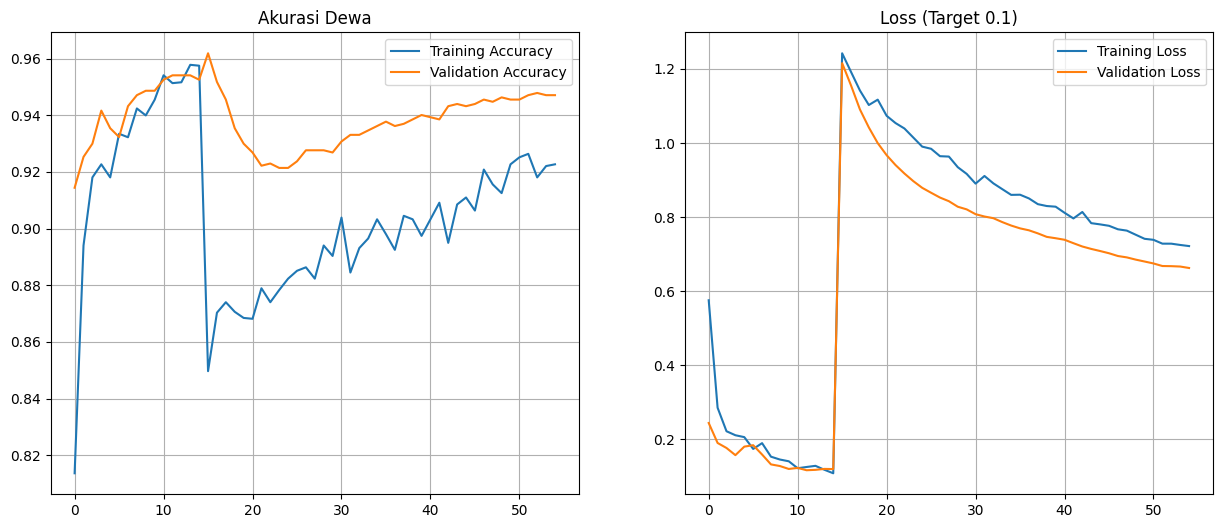

🎉 MISSION ACCOMPLISHED! Download file dimulai...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# ==========================================
# 8. SIMPAN & DOWNLOAD OTOMATIS 💾
# ==========================================
print("\n💾 Menyimpan Hasil Kerja Keras...")

# Save Model
model.save(MODEL_NAME)

# Save JSON
kamus_label = {str(v): k.replace("_", " ").upper() for k, v in train_data.class_indices.items()}
with open(JSON_NAME, 'w') as f:
    json.dump(kamus_label, f, indent=4)

# Plot Grafik
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Akurasi Dewa')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss (Target 0.1)')
plt.legend()
plt.grid(True)
plt.savefig('grafik_keren.png') # Simpan grafik juga
plt.show()

print("🎉 MISSION ACCOMPLISHED! Download file dimulai...")
files.download(MODEL_NAME)
files.download(JSON_NAME)
files.download('grafik_keren.png')

In [11]:
# ==========================================
# 9. FINAL EXAM (UJIAN AKHIR PAKE DATA TEST) 🎓
# ==========================================
print("\n🎓 MEMULAI UJIAN AKHIR (EVALUASI)...")

# Load model terbaik yang barusan di-save
print("⏳ Memuat model terbaik...")
best_model = tf.keras.models.load_model(MODEL_NAME)

# Tes ke data 'test'
results = best_model.evaluate(test_data, verbose=1)

print("\n" + "="*40)
print(f"🏆 HASIL AKHIR (DATA TEST MURNI)")
print("="*40)
print(f"📉 Test Loss:     {results[0]:.4f}")
print(f"🎯 Test Accuracy: {results[1]*100:.2f}%")
print("="*40)

if results[1] > 0.90:
    print("🌟 KESIMPULAN: Model Lu SAKTI MANDRAGUNA! (Akurasi > 90%)")
elif results[1] > 0.80:
    print("✅ KESIMPULAN: Model Lu CUKUP PINTER. (Akurasi > 80%)")
else:
    print("⚠️ KESIMPULAN: Perlu belajar lagi nih. (Akurasi < 80%)")


🎓 MEMULAI UJIAN AKHIR (EVALUASI)...
⏳ Memuat model terbaik...


8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.9518 - loss: 0.6318

🏆 HASIL AKHIR (DATA TEST MURNI)
📉 Test Loss:     0.6681
🎯 Test Accuracy: 92.97%
🌟 KESIMPULAN: Model Lu SAKTI MANDRAGUNA! (Akurasi > 90%)
